# Sentiment analysis

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
df = pd.read_parquet('s3://ling583/sentiment.parquet', storage_options={'anon': True})

-----

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.dummy import DummyClassifier

In [32]:
train1, test1 = train_test_split(
    df, test_size=0.2, stratify=df["sentiment"], random_state=619
)

In [33]:
test = test1.copy().reset_index(drop=True)
train = train1.copy().reset_index(drop=True)

In [34]:
# will assign the most common category to all examples
# that is, if we predict that every review is positive, we would be right ~73% of the time.
baseline = DummyClassifier() 
baseline.fit(train['text'], train['sentiment'])
print(accuracy_score(test['sentiment'], baseline.predict(test['text'])))

0.7322


-----

In [35]:
import nltk
nltk.download('vader_lexicon') # list of positive and negative words
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
analyzer = SentimentIntensityAnalyzer()

In [37]:
train['text'].iloc[0]

"I have been to New york before and stayed in the usual small rooms that Manhattan is abound with. Wingate in Midtown Manhattan though is in a league of its own! Location is excellent, Right behind Macy's. So if you wanna shop you are staying at the right place. TImes square is about a 15 mins walk. There are a few good eateries nearby, I would highly recommend the great bread factory which is just a 2 min walk. The rooms are large, the bathrooms are really well equipped, the staff very nice and friendly! Its just one fantastic Place! We are vegetarian and the breakfast held good options for us. A great way to start your day. if u are in Newyork look no further! Wingate is your best option (unles ofcourse you can afford the Waldorf astoria). The hotel room rates are simply fabulous! We were 5 of us and booked two double queen for two nights. (Traveling with parents). Seriously Stay Here!!"

In [38]:
analyzer.polarity_scores(_) # the _ in jupyter notebooks is a keyword for whatever the result was in the previous cell
# compound ranges from -1 to 1 


{'neg': 0.021, 'neu': 0.753, 'pos': 0.226, 'compound': 0.9909}

In [39]:
import multiprocessing as mp

In [40]:
def get_compound(text):
    return analyzer.polarity_scores(text)['compound']

with mp.Pool() as p:
    train['vader'] = list(p.imap(get_compound, tqdm(train['text']), chunksize=500))
    test['vader'] = list(p.imap(get_compound, tqdm(test['text']), chunksize=500))

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
train.head()
# in the sentiment column, 'bad' just means it has an overall score of less than 4 stars

,title,text,date_stayed,date,service,cleanliness,overall,value,location,sleep_quality,rooms,locality,name,sentiment,vader
0,“The Place to Stay in Manhattan! Simply Superb!”,I have been to New york before and stayed in t...,December 2008,2009-06-18,4.0,5.0,5.0,5.0,5.0,NaN,5.0,New York City,Wingate by Wyndham Manhattan Midtown,good,0.9909
1,"“Howard Johnson, Phoenix”",The hotel is located one mile from Sky Harbor ...,January 2012,2012-01-17,4.0,3.0,3.0,3.0,5.0,2.0,3.0,Phoenix,Howard Johnson Phoenix Airport/Downtown Area,bad,0.8656
2,“Pier 5 hotel was unlike any other hotel we ha...,Most hotels and hotel rooms look the same but ...,September 2009,2009-10-09,4.0,5.0,4.0,4.0,5.0,NaN,5.0,Baltimore,Pier 5 Hotel,good,0.9513
3,"“New York's best kept secret...well, not so se...","Excellent rooms, wonderful service......value ...",July 2011,2011-09-04,5.0,5.0,5.0,5.0,NaN,5.0,NaN,New York City,On The Ave Hotel,good,0.8126
4,“Cheerful Location-Best Value.”,We recently stayed for 5 nights in Hotel 140. ...,March 2012,2012-03-23,4.0,4.0,4.0,5.0,5.0,4.0,4.0,Boston,Hotel 140,good,0.9339


---

In [42]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'VADER composite')

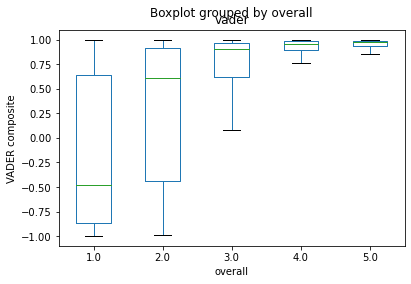

In [43]:
train.boxplot('vader', by='overall', grid=False, showfliers=False) # showfliers shows or hides outliers, in this case there are a lot of them
plt.ylabel('VADER composite')

In [44]:
accuracy_score((train['vader']>0.75),(train['sentiment']=='good'))

0.8085

In [45]:
xs = np.linspace(-1.0, 1.0, 50)
ys =[accuracy_score((train['vader']>x),(train['sentiment']=='good')) for x in xs]

Text(0, 0.5, 'Train acc.')

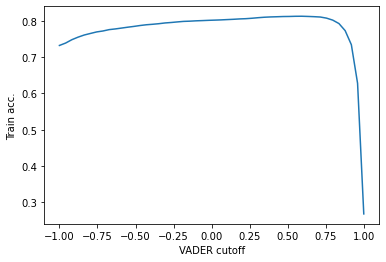

In [46]:
plt.plot(xs, ys)
plt.xlabel('VADER cutoff')
plt.ylabel('Train acc.')

In [47]:
# this gives us the cutoff value that gives us the highest accuracy
xs[np.argmax(ys)]

0.5918367346938773

In [48]:
thresh = _ # again, _ means use the output of the previous cell
accuracy_score((train['vader']>thresh),(train['sentiment']=='good'))

0.8127

In [49]:
accuracy_score((test['vader']>thresh),(test['sentiment']=='good'))

0.8179

---

In [50]:
# Vader score > .9 so vader thinks that it is a good review
# But it is actually a bad review
train[(train['vader']>.9)&(train['sentiment']=='bad')]['text'].iloc[0]

"You don't get what you pay for. This is a very very expnsive hotel for the ammenities you get. \nI spent $13.00 for a one page facsimile in their business center!\nI spent $50 bucks a night to park my car in the hotel.\nI spent $24 bucks for a drink in their bar.\nIf money is not an object, it's a beautiful hotel. It's conveniently located. Service is not bad but not 4 star that's for sure. The rooms are not bad but a bit on the small side. The food is decent. Their brunch is good and of course...very expensive.\nThere are better places for the money that I will stay at next time unless there is some special pricing going on here."

In [51]:
analyzer.polarity_scores(_)

{'neg': 0.009, 'neu': 0.816, 'pos': 0.174, 'compound': 0.97}

In [52]:
train[(train['vader']>.9)&(train['sentiment']=='bad')]['text'].iloc[1]

'I stayed for 10 days in a room in the second floor. The location is not far from freeway driveway wich was an advantage for me.The hotel is obviously ageing, but the room appeared to be clean. Breakfast was simple but ok. Regular coffee was very weak, could be much stronger because they also offer caffeine free coffee.\nRegarding the pool: Do not expect big sunny area around the pool. The pool is cooped up between the two wings of building and often in shade. There is not much space for sunbathing left. \nThe stuff was very friendly and helpful. \nResume: A hotel where you can go for shower and sleep without worrying about hygiene problems. For relaxing on the pool its defenetly not the right place.'

In [53]:
analyzer.polarity_scores(_)

{'neg': 0.077, 'neu': 0.719, 'pos': 0.203, 'compound': 0.966}

In [54]:
train[(train['vader']>.9)&(train['sentiment']=='bad')]['text'].iloc[2]

"The MO at San Francisco has the most amazing views. We booked a bridge to bridge view suite. Essentially this meant we could view the entire bay area from our room.\nThe hotel is in more of the business district than the tourist area, which didn't really bother us but might be a drag for others. The hotel forms part of an office building and at times it does feel like it. \nStaying at the weekend the hotel was very quiet and the bar area deadly in the evenings, you didn't really want to hang around and enjoy a pre dinner drink there. As I already mentioned it is in the business district and I suspect caterers more for the single business traveller.\nThe hotel was clean but it was beginning to look a little tired and drab. The bathroom in particular looked and felt like it had a long and hard life.\nWe had breakfast in the room every morning and this we loved. The service was quick and when an items was missing was very promptly replaced. \nThe bed was huge and very firm and position s

In [55]:
analyzer.polarity_scores(_)

{'neg': 0.058, 'neu': 0.779, 'pos': 0.163, 'compound': 0.9899}

In [56]:
def get_diff(text):
    scores = analyzer.polarity_scores(text)
    return scores['pos'] - scores['neg']

with mp.Pool() as p:
    train['vader_diff'] = list(p.imap(get_diff, tqdm(train['text']), chunksize=500))
    test['vader_diff'] = list(p.imap(get_diff, tqdm(test['text']), chunksize=500))

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'VADER pos - VADER neg')

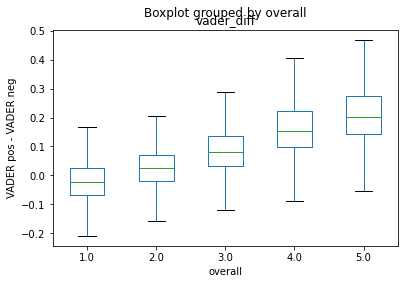

In [57]:
train.boxplot('vader_diff', by='overall', grid=False, showfliers=False)
plt.ylabel('VADER pos - VADER neg')

Text(0, 0.5, 'Train acc.')

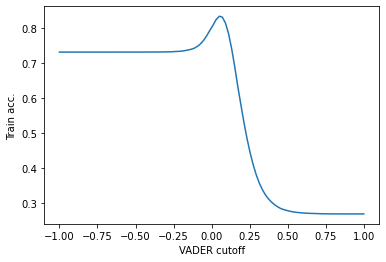

In [58]:
xs = np.linspace(-1.0, 1.0, 100)
ys =[accuracy_score((train['vader_diff']>x),(train['sentiment']=='good')) for x in xs]

plt.plot(xs, ys)
plt.xlabel('VADER cutoff')
plt.ylabel('Train acc.')

In [59]:
thresh = xs[np.argmax(ys)]
thresh

0.05050505050505061

In [60]:
accuracy_score((test['vader_diff']>thresh),(test['sentiment']=='good'))

0.837